In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import dlib
import numpy as np

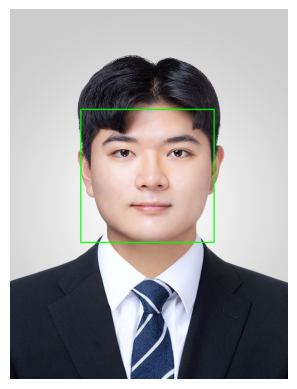

In [6]:
my_image_path = './data/camera_sticker/me.jpg' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

def detect_rect(image):
    
    detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dlib_rects = detector_hog(img_rgb, 1)
    
    for rects in dlib_rects:
        l = rects.left()
        r = rects.right()
        t = rects.top()
        b = rects.bottom()
    return dlib_rects, l, r, t, b

def plot_rect(image,l,r,t,b,save=False):
    cv2.rectangle(image, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림
    img_show_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(img_show_rgb)
    if save:
        plt.savefig('detected_rect.jpg')
    plt.show()

dlib_rects, l,r,t,b=detect_rect(img_bgr)
plot_rect(img_show, l,r,t,b)

68


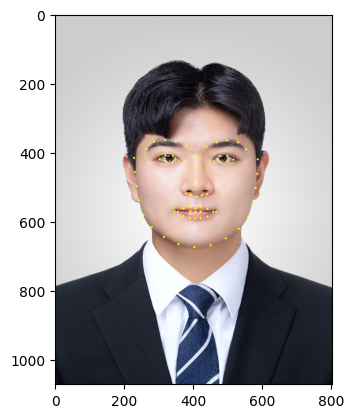

In [7]:
# bgr 이미지를 받아 landmark를 감지하는 함수
my_image_path = './data/camera_sticker/me.jpg' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

model_path = './models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄


def detect_landmarks(image):
    list_landmarks = []
    
    detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dlib_rects = detector_hog(img_rgb, 1)

    for rects in dlib_rects:
        points = landmark_predictor(img_rgb, rects)
        list_points = list(map(lambda p: (p.x, p.y), points.parts())) # 각각의 landmark 위치정보를 (x,y)형태로 변환하여 list에 저장
        list_landmarks.append(list_points)
        
    print(len(list_landmarks[0]))
    
    return list_landmarks

def plot_landmark(img, list_landmarks):
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img, point, 3, (0, 255, 255), -1)
    img_show_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    plt.show()
    
list_landmarks = detect_landmarks(img_bgr)
plot_landmark(img_bgr, list_landmarks)

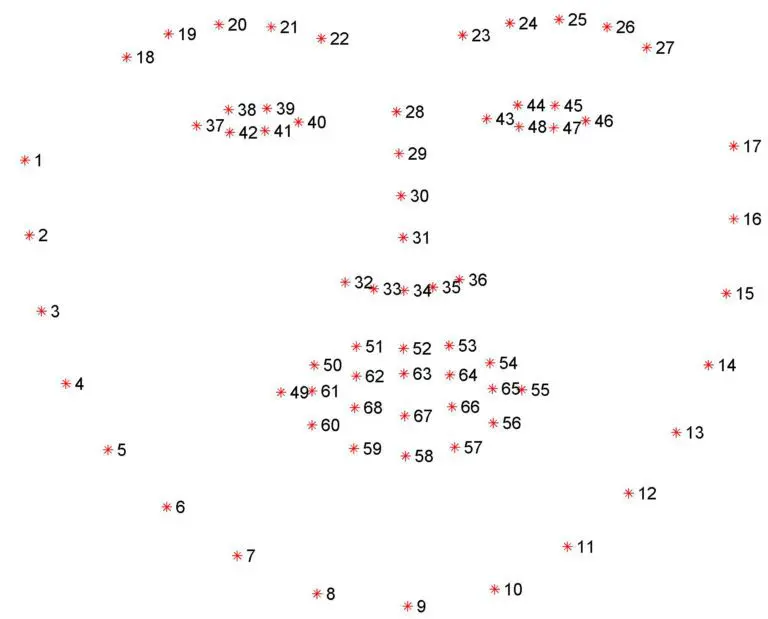
* The mouth can be accessed through points [48, 68].
* The right eyebrow through points [17, 22].
* The left eyebrow through points [22, 27].
* The right eye using [36, 42].
* The left eye with [42, 48].
* The nose using [27, 35].
* And the jaw via [0, 17].  
https://pyimagesearch.com/2017/04/10/detect-eyes-nose-lips-jaw-dlib-opencv-python/

랜드마크 기준 눈썹 위 얼굴 중앙에 스티커를 씌워봅시다  
1. 스티커 위치  
$x = x_{nose}$  
$y = y_{nose} - \frac{height}{2}$
2. 스티커 크기  
$width = height = width_{bbox}$

In [13]:
for rects, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])# 코의 위치는 30이다
    x = landmark[30][0] # 코 부위의 x값
    y = landmark[30][1] - rects.height()//2 # 수식2 : 코 위치 - 얼굴 세로길이//2
    w = h = rects.width() # 수식3: 얼굴의 가로길이
    print(f'(x,y) : ({x},{y})')
    print(f'(w,h) : ({w},{h})')

(409, 495)
(x,y) : (409,302)
(w,h) : (386,386)


In [28]:
# 이미지 시작점은 top-left좌표이기 때문에 사이즈, 좌표를 조정해 준다.
sticker_path = './data/camera_sticker/hat/king.png'

img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

(386, 386, 3)


In [29]:
refined_x = w - x//2
refined_y = y - h
print(f'(x,y) : ({refined_x},{refined_y})') #이마 위치 - 왕관 높이를 했더니 음수 발생
# opencv는 ndarray를 사용하는데, ndarray는 음수 인덱스에 접근 불가하므로 스티커 이미지를 잘라줘야 한다.

(x,y) : (182,-84)


In [30]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 왕관 이미지를 씌우기 위해 왕관 이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] # refined_y가 -98이므로, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (182,0)


In [31]:
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.
# 예제에서는 (344,0) 부터 (344+187, 0+89) 범위의 이미지를 의미합니다.
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_show[0:0+89, 344:344+187]
# img_show[0:89, 344:531]
# 즉, x좌표는 344~531 / y좌표는 0~89가 됨
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# 왕관 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 왕관 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# 현재 왕관 이미지에서는 왕관과 받침대 밑의 ------ 부분이 됨
# 그렇기 때문에 0인 부분(이미지가 없는 부분)은 제외하고 적용
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 왕관 이미지에서 왕관 이미지가 없는 부분(왕관과 받침대 밑의 ------ 부분)은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(왕관 이미지에서 왕관 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(왕관 이미지)를 적용한다.
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

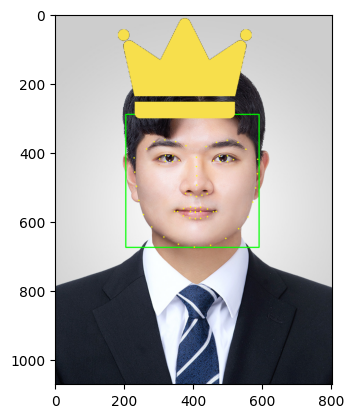

In [32]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 고양이 수염 이미지

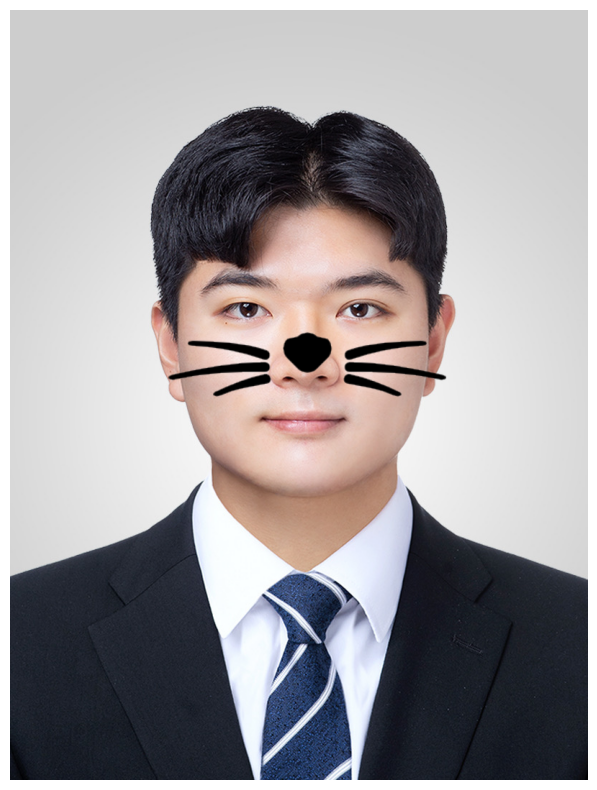

In [33]:
sticker_path = './data/camera_sticker/beard/cat-whiskers.png'

# 스티커 이미지 불러오기
img_sticker = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED)
img_sticker = cv2.resize(img_sticker, (w,h))

# 스티커 이미지 알파 채널 추출하기
alpha_s = img_sticker[:, :, 3] / 255.0
alpha_l = 1.0 - alpha_s

refined_x, refined_y = 220, 300
# 인식된 얼굴 영역 추출하기
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# 스티커 이미지 합성하기
for c in range(0, 3):
    sticker_area[:, :, c] = (alpha_s * img_sticker[:, :, c] + alpha_l * sticker_area[:, :, c])

# 합성된 스티커 이미지를 원본 이미지에 적용하기
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = sticker_area

# BGR 이미지를 RGB 이미지로 변환하여 출력하기
plt.figure(figsize=(10,10))
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

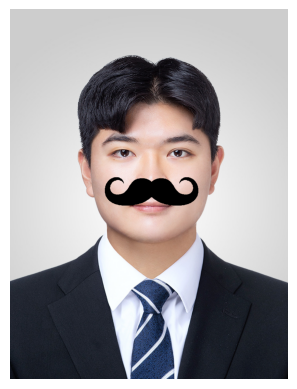

In [8]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

# Load images
img_bgr = cv2.imread('./data/camera_sticker/me.jpg')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_mustache = cv2.imread('./data/camera_sticker/beard/moustache.png', cv2.IMREAD_UNCHANGED)

# Detect faces in the image
dlib_rects = detector(img_rgb)

# Iterate over detected faces and apply mustache
for rect in dlib_rects:
    # Extract landmarks
    landmarks = predictor(img_rgb, rect)
    list_landmarks = []
    for i in range(0, landmarks.num_parts):
        list_landmarks.append((landmarks.part(i).x, landmarks.part(i).y))

    # Calculate nose location
    nose_tip = list_landmarks[33] #(409, 528)
    nose_bottom = list_landmarks[30] # (409, 495)
    nose_width = 300#nose_bottom[0] - nose_tip[0]

    # Resize mustache image to fit nose width
    mustache_resized = cv2.resize(img_mustache, (nose_width, int(nose_width / img_mustache.shape[1] * img_mustache.shape[0])))

    # # Rotate mustache image to align with nose angle
    # angle = np.rad2deg(np.arctan2(nose_bottom[1] - nose_tip[1], nose_bottom[0] - nose_tip[0]))
    # center = (mustache_resized.shape[1] // 2, mustache_resized.shape[0] // 2)
    # M = cv2.getRotationMatrix2D(center, angle, 1)
    # mustache_rotated = cv2.warpAffine(mustache_resized, M, (mustache_resized.shape[1], mustache_resized.shape[0]))

    # Calculate position to place mustache
    mustache_x = nose_tip[0] - nose_width // 2
    mustache_y = nose_tip[1] - mustache_resized.shape[0] // 2

    # Superimpose mustache image onto face image
    img_show = np.copy(img_bgr)
    sticker_area = img_show[mustache_y:mustache_y + mustache_resized.shape[0], mustache_x:mustache_x + mustache_resized.shape[1], :]
    img_show[mustache_y:mustache_y + mustache_resized.shape[0], mustache_x:mustache_x + mustache_resized.shape[1], :] = \
        np.where(mustache_resized[:, :, 3][:, :, np.newaxis] > 0, mustache_resized[:, :, :3], sticker_area).astype(np.uint8)
        
    # sticker_area = img_show[mustache_y:mustache_y + mustache_rotated.shape[0], mustache_x:mustache_x + mustache_rotated.shape[1], :]
    # img_show[mustache_y:mustache_y + mustache_rotated.shape[0], mustache_x:mustache_x + mustache_rotated.shape[1], :] = \
    #     np.where(mustache_rotated[:, :, 3][:, :, np.newaxis] > 0, mustache_rotated[:, :, :3], sticker_area).astype(np.uint8)

# Show resulting image
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.savefig('result.png')
plt.show()

1. 여러가지 이미지 적용해보기
2. 얼굴 회전 처리하기